LLaVA
====

* Paper:
    * "Visual Instruction Tuning": https://arxiv.org/abs/2304.08485
    * "Improved Baselines with Visual Instruction Tuning" https://arxiv.org/pdf/2310.03744

![LlAVA-1.5](../assets/llava15-overview.png)

```bash
pip install torch torchvision
pip install transformers
pip install matplotlib
pip install supervision
```

In [1]:
import base64
from io import BytesIO
from PIL import Image

import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

# Load the model in half-precision
model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf", torch_dtype=torch.float16, device_map="auto")
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
image1 = Image.open("../samples/fruits-01.jpg")

def load_image_as_base64(image):
    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

image1_base64 = load_image_as_base64(image1)

conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "data:image/jpeg;base64," + image1_base64},
            {"type": "text", "text": "What is shown in this image?"},
        ],
    },
]

inputs = processor.apply_chat_template(
    conversation, add_generation_prompt=True,
    tokenize=True, return_dict=True, return_tensors="pt"
)
inputs = inputs.to("cuda:0", torch.float16)

inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values'])

In [3]:
output = model.generate(**inputs, max_new_tokens=100)
print(processor.decode(output[0], skip_special_tokens=True))

USER:  
What is shown in this image? ASSISTANT: The image shows a bowl filled with various fruits and vegetables, including blueberries, raspberries, cucumbers, and possibly other fruits and vegetables.


In [4]:
image2 = Image.open("../samples/plants.jpg")
image2_base64 = load_image_as_base64(image2)

conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "data:image/jpeg;base64," + image2_base64},
            {"type": "text", "text": "What is shown in this image?\n"},
        ],
    },
]

inputs = processor.apply_chat_template(
    conversation, add_generation_prompt=True,
    tokenize=True, return_dict=True, return_tensors="pt"
)
inputs = inputs.to("cuda:0", torch.float16)

output = model.generate(**inputs, max_new_tokens=100)
print(processor.decode(output[0], skip_special_tokens=True))

USER:  
What is shown in this image?
 ASSISTANT: The image shows two potted plants, one of which is a large leafy plant, placed on a wooden floor. The potted plants are positioned next to each other, and they are placed on a metal stand or a metal tray. The scene appears to be indoors, possibly in a living room or a similar space.


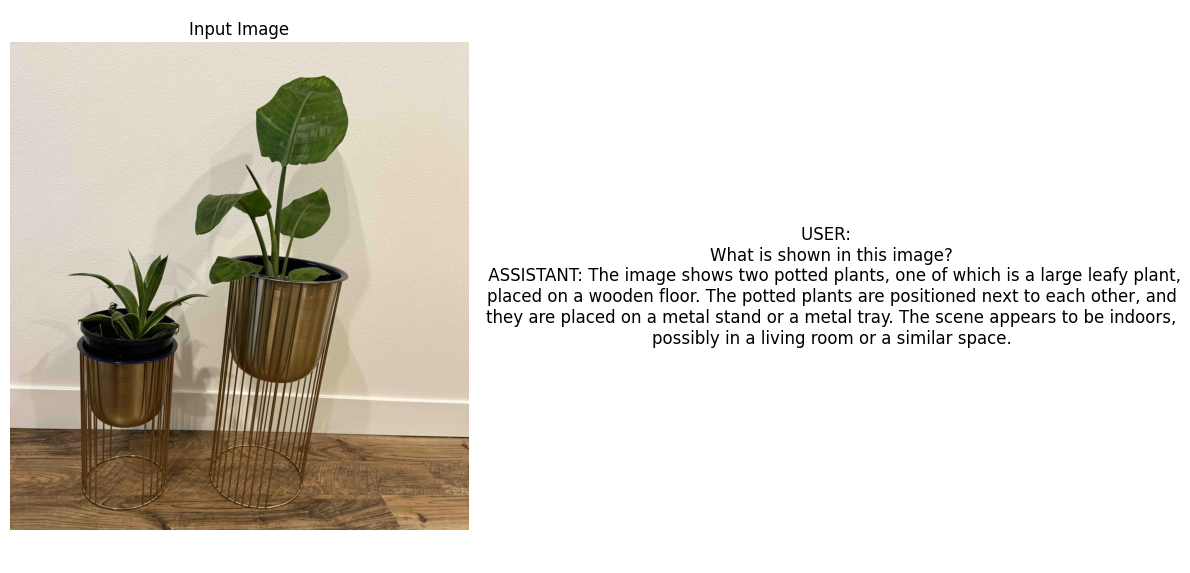

In [5]:
import matplotlib.pyplot as plt

response = processor.decode(output[0], skip_special_tokens=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image2)
axes[0].axis("off")
axes[0].set_title("Input Image")
axes[1].text(
    0.5, 0.5, response,
    fontsize=12, ha="center", va="center", wrap=True
)
axes[1].axis("off")
plt.tight_layout()
plt.show()